# Table of Contents
* [Description](#Description)
* [Import Python Modules](#Import-Python-Modules)
* [Import Images (Data and OB)](#Import-Images-%28Data-and-OB%29)
	* [Load Data](#Load-Data)
	* [Preview Data](#Preview-Data)
	* [Load and Bin OB](#Load-and-Bin-OB)
		* [Select Folder than Contain all the OBs](#Select-Folder-than-Contain-all-the-OBs)
		* [Checking that Number of Data = Number of OB Files](#Checking-that-Number-of-Data-=-Number-of-OB-Files)
		* [Load OB](#Load-OB)


# Description

This notebook allows the user to normalized the data using the set of OB folders.

1. you will need to specify the location of the OB folders
2. Then the program will load the data of only a specified bin
3. user will select a ROI outside the sample region
4. program will normalized by matching the intensity of the OB and data ROIs

# Import Python Modules 

In [1]:
verbose = False
debugging = False

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

if os.sys.platform == 'darwin':
    sys.path.append('/Users/j35/git/BraggEdge/python')
else:
    sys.path.append(r"C:\Users\user\Documents\GitHub\BraggEdge\python")
    sys.path.append(r"C:\Users\user\Anaconda3\envs\SNAP2016\lib\site-packages")
 
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge
from neutronbraggedge.material_handler.retrieve_material_metadata import RetrieveMaterialMetadata

import config_handler
import file_handler
import math_handler
import utilities
import gui_widgets

In [2]:
%gui qt

# Import Images (Data and OB) 

## Import Bin -> Temperature File 

In [3]:
#import T vs bin_index file
output_folder = config_handler.load_config(key = 'output_folder')
file_name = os.path.join(output_folder, 'binning_list_of_files.csv')

df = pd.read_csv(file_name, index_col=0, header=None)
list_temperature_for_each_bin = []
for _temp in df.loc['temperature',:]:
    list_temperature_for_each_bin.append(_temp)

## Load Data 

In [4]:
input_folder = config_handler.load_config(key='output_folder')
list_bins = glob.glob(input_folder + '/bin#*')

In [5]:
list_bins_user_friendly = utilities.make_user_friendly_list_of_bins(list_bins)
bins_vs_T_dict = {}
for _index, _bin_name in enumerate(list_bins_user_friendly):
    bins_vs_T_dict[_bin_name] = list_temperature_for_each_bin[_index]
list_bins_widget = widgets.Select(options=list_bins_user_friendly,
                        description = "Select Bin with Sample Visible")
display(list_bins_widget)

In [6]:
list_images = glob.glob(os.path.join(input_folder, list_bins_widget.value) + '/*.fits')
nbr_images = len(list_images)

#import images
w = widgets.IntProgress()
w.max = len(list_images)-1
display(w)

data_array = []  #[nbr_files, height, width]
for _index, _file in enumerate(list_images):
    _image = file_handler.read_single_fits(_file)
    data_array.append(_image)
    w.value = _index

data_array = np.squeeze(data_array)
#w.visible = False

## Preview Data 

1241

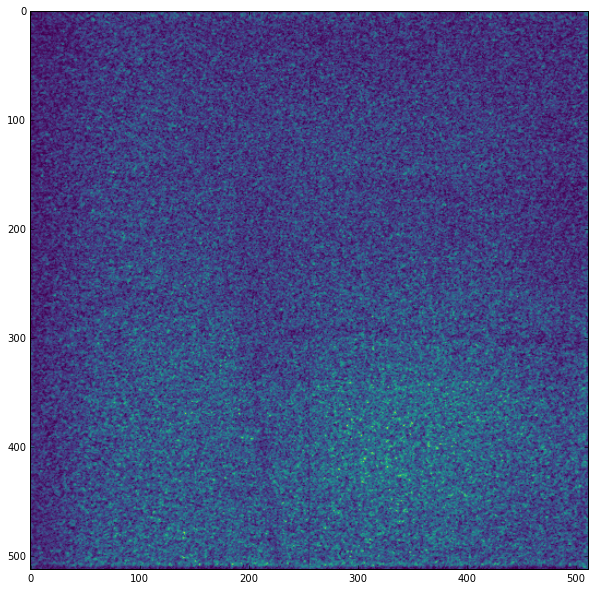

In [15]:
def plot_images(image_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data_array[image_index], cmap='viridis')
    
    return image_index
    
preview = interact(plot_images,
                  image_index = widgets.IntSlider(min=0, 
                                                max=len(list_images)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index'))

## Preview Bragg Edges peak from ROI

[250, 180, 200, 100]

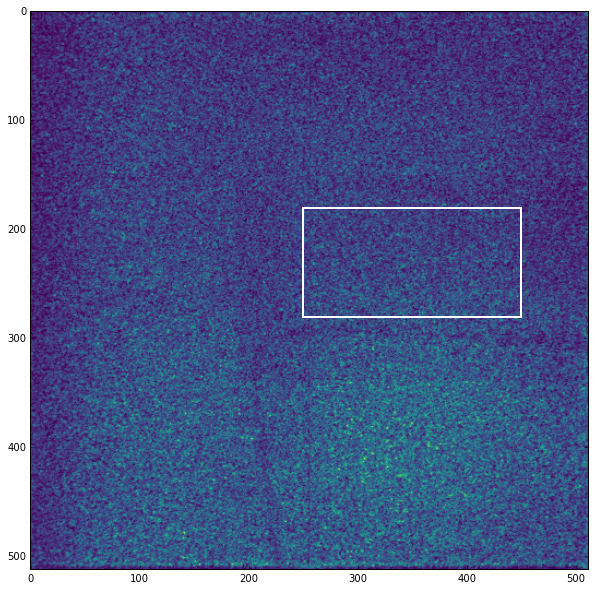

In [17]:
image_index = preview.widget.result
[height, width] = np.shape(data_array[0])

def plot_images(x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data_array[image_index],
                 cmap='viridis')
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    data_cropped = [_data[y_top:y_top+height, x_left:x_left+width] for _data in data_array]
    mean_counts_selection_1 = np.mean(data_cropped, axis=1)
    mean_counts_selection = np.mean(mean_counts_selection_1, axis=1)
    
    trace_data = go.Scatter(y=mean_counts_selection,
                           name='data',
                           mode='markers')
    data = [trace_data]

    figure1 = go.Figure(data=data)
    iplot(figure1)
    
    return [x_left, y_top, width, height]
    
preview_bragg_edge = interact(plot_images,
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=250,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=180,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=200,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=100,
                                            description='Height'))

## Load and Bin OB

### Select Folder than Contain all the OBs

In [18]:
ob_folder = gui_widgets.gui_dname(dir=input_folder,
                                message='Select the Root OB folder ...')
list_ob_folder = glob.glob(ob_folder + '/*')

# make sure name is folder
list_ob_folder = [_folder for _folder in list_ob_folder if os.path.isdir(_folder)]

### Checking that Number of Data = Number of OB Files 

In [19]:
list_ob = glob.glob(list_ob_folder[0] + '/*.fits')
# remove Summed image file from list
list_ob = file_handler.remove_SummedImg_from_list(list_ob)
nbr_ob = len(list_ob)

display(HTML('<span style="font-size: 20px">Does number of Data match number of OB: '))
if nbr_ob == nbr_images:
    display(HTML('<span style="color:green">OK!</span></span'))
else:
    display(HTML('<span style="color:red">FAILED!</span></span'))
    print()
    display(HTML('-> number of data: ' + "{}".format(nbr_images)))
    display(HTML('-> number of OB: ' + "{}".format(nbr_ob)))


### Load OB 

In [20]:
#import images
w = widgets.IntProgress()
w.max = len(list_ob_folder)
display(w)

ob_array = []
for _index, _folder in enumerate(list_ob_folder):
    list_ob = glob.glob(_folder + '/*.fits')
    list_files = list_ob = file_handler.remove_SummedImg_from_list(list_ob)
    _folder_images = file_handler.read_fits(list_files)
    ob_array.append(_folder_images)
    w.value = _index+1
    
#w.visible = False

### Bin OBs  

In [21]:
if np.shape(ob_array)[0] > 1:
    algo_selected = config_handler.load_config(key='rebin_algo')

    if algo_selected == 'mean': #mean
        ob_binned = np.mean(ob_array, axis=0)
    elif algo_selected == 'add': #add
        ob_binned = np.add(ob_array, axis=0)

else:
    ob_binned = np.squeeze(ob_array)
        
[width, height] = np.shape(ob_binned[0])

# Select ROI

[1, 1, 180, 510]

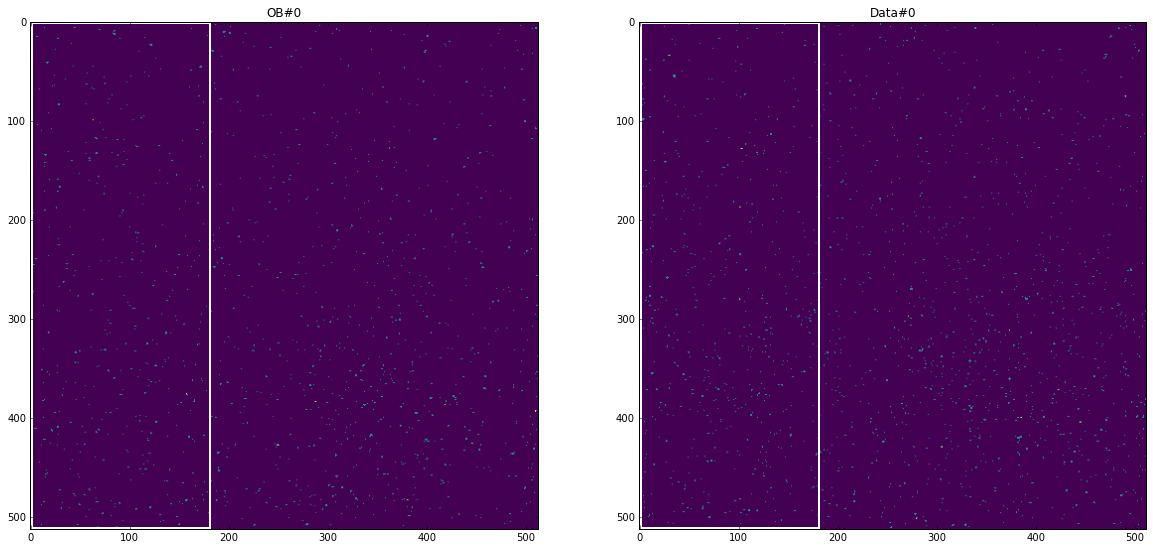

In [22]:
def plot_images(file_index, x_left, y_top, width, height):

    #OB
    fig = plt.figure(figsize=(20,20))
    ax_img = plt.subplot(121)
    ax_img.imshow(ob_binned[file_index],
                 cmap='viridis')
    ax_img.set_title("OB#{}".format(file_index))
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    #data
    ax_data = plt.subplot(122)
    ax_data.imshow(data_array[file_index],
                 cmap='viridis')
    ax_data.set_title("Data#{}".format(file_index))
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_data.add_patch(_rectangle)
    
    return [x_left, y_top, width, height]
    
preview = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=nbr_ob-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=1,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=1,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=180,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=510,
                                            description='Height'))

# Preview 2D Mean Counts vs File Index 

In [23]:
[x_left, y_top, width_roi, height_roi] = preview.widget.result

ob_binned_cropped = [
    _ob[y_top:y_top + height_roi, x_left:x_left + width_roi]
    for _ob in ob_binned
]
ob_mean_phase_1 = np.mean(ob_binned_cropped, axis=1)
ob_mean_roi = np.mean(ob_mean_phase_1, axis=1)

data_cropped = [
    _data[y_top:y_top + height_roi, x_left:x_left + width_roi]
    for _data in data_array
]
data_mean_phase_1 = np.mean(data_cropped, axis=1)
data_mean_roi = np.mean(data_mean_phase_1, axis=1)

trace_ob = go.Scatter(y=ob_mean_roi, name='OB', mode='markers')
trace_data = go.Scatter(y=data_mean_roi, name='data', mode='markers')
data = [trace_ob, trace_data]

_temperature = bins_vs_T_dict[list_bins_widget.value]
layout = go.Layout(
    width="100%",
    height=500,
    title='Mean Counts of ROI for T={:04.2f}C'.format(float(_temperature)),
    xaxis=dict(title="File Index"),
    yaxis=dict(title="Mean Counts"))

figure1 = go.Figure(data=data, layout=layout)
iplot(figure1)

# Perform Normalization

In [25]:
full_list_images = []
for _folder in list_bins:
    list_images = glob.glob(os.path.join(_folder + '/*.fits'))
    full_list_images.append(list_images)

#import images
w = widgets.IntProgress()
w.max = len(list_bins)
display(w)

_index = 0
normalized_data_array = []
final_list_temperature_for_each_bin = []

for _index, _list_data_files in enumerate(full_list_images):

    if _list_data_files == []:
        _index += 1
        w.value = _index
        continue

    final_list_temperature_for_each_bin.append(list_temperature_for_each_bin[
        _index])

    #load data [1482, 512, 512]
    data_array = file_handler.read_fits(_list_data_files)
    data_array = np.squeeze(data_array)

    data_cropped = [
        _data[y_top:y_top + height_roi, x_left:x_left + width_roi]
        for _data in data_array
    ]
    data_mean_phase_1 = np.mean(data_cropped, axis=1)
    data_mean_roi = np.mean(data_mean_phase_1, axis=1)

    #calculation of coefficient [1482]
    coeff_array = np.divide(data_mean_roi, ob_mean_roi)

    data_and_coeff_and_ob_array = list(zip(data_array, coeff_array, ob_binned))

   
    normalized_data = [
        np.divide(np.divide(_array, _ob), _coeff)
        for [_array, _coeff, _ob] in data_and_coeff_and_ob_array
    ]
    normalized_data_array.append(normalized_data)
#    print(np.shape(normalized_data_array))
    
    if debugging:

        sample = dict(x_left = 250,
            y_top = 180,
            width_roi = 200,
            height_roi = 100)

        data_cropped_1 = [
            _data[sample['y_top']:sample['y_top'] + sample['height_roi'], 
                  sample['x_left']:sample['x_left'] + sample['width_roi']]
            for _data in normalized_data
        ]
        data_mean_phase_1 = np.mean(data_cropped, axis=1)
        data_mean_roi = np.mean(data_mean_phase_1, axis=1)

        trace_data = go.Scatter(
            y=data_mean_roi, name='normalized data', mode='markers')
        data = [trace_data]
        figure1 = go.Figure(data=data)
        iplot(figure1)

    _index += 1
    w.value = _index

#w.visible = False

/Users/j35/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning:

divide by zero encountered in true_divide

/Users/j35/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning:

invalid value encountered in true_divide



(1, 1482, 512, 512)
(2, 1482, 512, 512)
(3, 1482, 512, 512)
(4, 1482, 512, 512)
(5, 1482, 512, 512)
(6, 1482, 512, 512)
(7, 1482, 512, 512)
(8, 1482, 512, 512)
(9, 1482, 512, 512)
(10, 1482, 512, 512)
(11, 1482, 512, 512)
(12, 1482, 512, 512)
(13, 1482, 512, 512)
(14, 1482, 512, 512)
(15, 1482, 512, 512)


# Checking Normalization

### Plotting OB region of data 

In [ ]:
[x_left, y_top, width_roi, height_roi] = preview.widget.result
ob_mean_roi = [np.mean(np.mean(_ob[y_top:y_top+height_roi][x_left:x_left+width_roi],axis=0), 
                       axis=0) for _ob in ob_binned]

user_friendly_list_of_T = ["{:04.2f}C".format(float(_temp)) for _temp in final_list_temperature_for_each_bin]

In [37]:
if verbose:

def get_list__T_index_to_display(list_of_T_to_plot):

    list_index = []
    for _index, _T in enumerate(user_friendly_list_of_T):
        if _T in list_of_T_to_plot:
            list_index.append(_index)

    return list_index

def plot_preview(list_of_T_to_plot):

    if verbose:
        trace_ob = go.Scatter(y=ob_mean_roi,
                             name='OB',
                         mode='markers')
        data = [trace_ob]

    list_T_index_to_display = get_list__T_index_to_display(list_of_T_to_plot)

    for _index_bin in list_T_index_to_display:

        _bin_array= normalized_data_array[_index_bin]
        data_mean_roi = [np.mean(np.mean(_data[y_top:y_top+height_roi][x_left:x_left+width_roi],axis=0), 
                           axis=0) for _data in _bin_array]

        _temperature = final_list_temperature_for_each_bin[_index_bin]
        if verbose:
            trace_data = go.Scatter(y=data_mean_roi,
                                   name='T={:04.2f}C'.format(float(_temperature)),
                                   mode='markers')
            data.append(trace_data)

    if verbose:
        layout= go.Layout(width="100%",
                         height=500,
                         title='Mean Counts of ROI for all T',
                         xaxis= dict(title="File Index"),
                         yaxis= dict(title="Mean Counts"))

        figure1 = go.Figure(data=data, layout=layout)
        iplot(figure1)

preview_result = interact(plot_preview,
                         list_of_T_to_plot = widgets.SelectMultiple(options=user_friendly_list_of_T,
                                                                   description = 'Select Temp. to Plot',
                                                                   value = user_friendly_list_of_T))

### Checking Bragg Edge Profile

In [31]:
data_bin_of_interest = normalized_data_array[14]
np.shape(data_bin_of_interest)

(1482, 512, 512)

In [33]:
[x_left, y_top, width, height] = preview_bragg_edge.widget.result

def plot_bragg_edge(bin_index):

    data_bin_of_interest = normalized_data_array[bin_index]
    data_cropped = []
    for _data in data_bin_of_interest:
        data_cropped.append(_data[y_top:y_top + height, x_left:x_left + width])
    mean_counts_selection_1 = np.mean(data_cropped, axis=1)
    mean_counts_selection = np.mean(mean_counts_selection_1, axis=1)

    trace_data = go.Scatter(
        y=mean_counts_selection, name='normalized data', mode='markers')
    data = [trace_data]

    figure1 = go.Figure(data=data)
    iplot(figure1)


check = interact(
    plot_bragg_edge,
    bin_index=widgets.IntSlider(
        min=0,
        max=len(list_bins_user_friendly) - 1,
        step=1,
        value=0,
        description='Bin Index'))

# Export Normalized File 

In [38]:
# create normalized folder

output_folder = config_handler.load_config(key='output_folder')
normalized_output_folder = os.path.join(output_folder, 'normalized')
file_handler.make_or_reset_folder(normalized_output_folder)

In [39]:
# retrieve list of output file names (full_list_images)
short_name_list_images = [[os.path.basename(_file) for _file in bin_list] for bin_list in full_list_images]

In [40]:
#export images
w = widgets.IntProgress()
w.max = len(list_bins)
display(w)

for _index_bin, _bin in enumerate(user_friendly_list_of_T):
    _bin_folder_name = os.path.join(normalized_output_folder, _bin)
    file_handler.make_or_reset_folder(_bin_folder_name)

    full_name_list = [os.path.join(_bin_folder_name, _file) for _file in short_name_list_images[_index_bin]]
    for _index_file, _file in enumerate(full_name_list):
        _name = _file
        _data = normalized_data_array[_index_bin][_index_file]
        file_handler.make_fits(data=_data, filename=_file)
    
    w.value = _index_bin+1
    
w.visible=False